In [1]:
%pylab notebook
import numpy as np
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [ ]:
class IsingSimulator:
    def __init__(self, l=20, InvTemp=1.0, j_inter=1.0, b_ext=0.0):
        self.latticeSize = l
        self.lattice = np.zeros((l,l),dtype=np.int)
        self.B_ext = b_ext
        self.J_interact = j_inter
        self.invTemp = InvTemp
        
    def randomConformation(self):
        # create random array with -1 or 1
        self.lattice = ( ( np.random.randint(0,2,(self.latticeSize,self.latticeSize)) * 2 ) - 1)
        
    def calcMagnetisation(self):
        return float(self.lattice.sum()) / float(self.lattice.size )
        
    def singleSpinenergy(self, x, y):
        # here we go for periodic boundary conditions:
        left  = x - 1 if x > 0 else ( self.latticeSize - 1 )
        right = x + 1 if x < ( self.latticeSize - 1 ) else 0
        down  = y + 1 if y < ( self.latticeSize - 1 ) else 0
        up    = y - 1 if y > 0 else ( self.latticeSize - 1 )
        
        # also possible, but slower due to %-operator
        #nb = 0.5 * self.J_interact * ( 
        #    self.lattice[(x+1)%self.latticeSize,y] + 
        #    self.lattice[x,(y+1)%self.latticeSize] + 
        #    self.lattice[(x-1)%self.latticeSize,y] + 
        #    self.lattice[x,(y-1)%self.latticeSize] )
        
        # E = - B_ext * S_i - 1/2 * J * S_i * sum_Sj_next_neighbors
        return -1.0 * self.lattice[x,y] * ( self.B_ext + 0.5 * self.J_interact * (
            self.lattice[x,up] + self.lattice[x,down] + self.lattice[left,y] + self.lattice[right,y] ) )
    
    def calcEnergy(self):
        E = 0.0
        for x in range(self.latticeSize):
            for y in range(self.latticeSize):
                E += self.singleSpinenergy(x,y)
        return -E/self.lattice.size
    
    def performMCS(self, time):
        # check if lattice was initialised
        if self.lattice[0,0] == 0:
            self.randomConformation()
            
        #counter for accepted moves
        counter = 0
        
        # do the loop
        for t in range(time):
            # get random x,y coordinates @ students ???? what could be done to optimize????
            randX = np.random.randint(0,self.latticeSize,(self.latticeSize))
            randY = np.random.randint(0,self.latticeSize,(self.latticeSize))
            for x, y in zip(randX, randY):
                e_old = self.singleSpinenergy(x, y)
                # do the "test" flip
                e_new = -e_old
                # apply metropolis
                prob =np.exp( - (e_new - e_old) * self.invTemp)
                #print(e_old, e_new, prob)

                if np.random.random_sample() < prob:
                    self.lattice[x,y] *= -1
                    counter += 1
                    
        return counter
                
                
    def plotConfig(self):
        plt.figure(dpi=90)
        plt.pcolormesh(self.lattice)
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title('spatial magnetisation')
        plt.show()
        
    def plotEquilibrationRun(self):
        self.randomConformation()
        nMCS = 20
        time = []
        magnetisation = []
        for i in range(100):
            self.performMCS(nMCS)
            time.append(nMCS*i)
            magnetisation.append(self.calcMagnetisation())
        
        plt.figure(dpi=120)
        plt.plot(time, magnetisation, 'g+')

In [3]:
def runIsingSimulationSimple(l=20, InvTemp=1.0, j_inter=1.0, b_ext=0.0, nSteps=1000):
    ising = IsingSimulator(l, InvTemp, j_inter, b_ext)
    energy = []
    energy2 = []
    magnet = []
    bolzma = []
    # run simulations
    for t in range(nSteps):
        ising.randomConformation()
        e = ising.calcEnergy()
        bolz = np.exp(-e*InvTemp)
        bolzma.append(bolz)
        energy.append(e * bolz)
        energy2.append(e * e * bolz)
        magnet.append(ising.calcMagnetisation() * bolz)
        
    # calculate averages
    aveEner = sum(energy) / (sum(bolzma) * nSteps)
    aveEner2 = sum(energy2) / (sum(bolzma) * nSteps)
    aveMagn = sum(magnet) / (sum(bolzma) * nSteps)
    heatcap = InvTemp * InvTemp * ( aveEner2 - aveEner*aveEner )
    
    return aveMagn, aveEner, heatcap

In [12]:
runIsingSimulationSimple(20, 4.0, 1.0, 0.0, 10000)


(-1.2216154865456757e-08, -1.945470590400707e-06, 7.941770722579363e-10)

In [ ]:
temp = []
magnetisierung = []
energie = []
waermekapazitaet = []
for T in np.arange(0.1, 3, 0.02):
    m, e, c = runIsingSimulationSimple(20, 1.0/T, 1.0, 0.0, 10000)
    temp.append(T)
    magnetisierung.append(np.fabs(m))
    energie.append(e)
    waermekapazitaet.append(c)
    
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True)
ax1.plot(temp,magnetisierung,'g+')
ax1.set( ylabel='M' )
ax2.plot(temp,energie,'ro')
ax2.set( ylabel='E')
ax3.plot(temp,waermekapazitaet,'b.')
ax3.set( ylabel='C', xlabel='T', )
ax3.set_xlim(0,4)

plt.show()

In [6]:
def runImportanceSampling(l=20, InvTemp=1.0, j_inter=1.0, b_ext=0.0, nSteps=10):
    ising = IsingSimulator(l, InvTemp, j_inter, b_ext)
    energy  = []
    energy2 = []
    magnet  = []
    
    # do the equilibration
    ising.performMCS(2000)
    # run simulations
    for t in range(nSteps):
        ising.performMCS(200)
        e = ising.calcEnergy()
        energy.append(e)
        energy2.append(e*e)
        magnet.append(ising.calcMagnetisation())
        
    # calculate averages
    aveEner = sum(energy) / nSteps
    aveMagn = sum(magnet) / nSteps
    heatcap = InvTemp * InvTemp * ( sum(energy2)/nSteps - aveEner*aveEner )
    
    return aveMagn, aveEner, heatcap

In [ ]:
temp = []
magnetisierung = []
energie = []
waermekapazitaet = []
for T in np.arange(0.1, 3, 0.02):
    m, e, c = runImportanceSampling(20, 1.0/T, 1.0, 0.0, 10000)
    temp.append(T)
    magnetisierung.append(np.fabs(m))
    energie.append(e)
    waermekapazitaet.append(c)
    
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True)
beta_0=0.86
T_C=1/beta_0
ax1.plot(temp,magnetisierung,'g+')
ax1.set( ylabel='M' )
ax2.plot(temp,energie,'ro')
ax2.set( ylabel='E')
ax3.plot(temp,waermekapazitaet,'b.')
ax3.set( ylabel='C', xlabel='T', )
ax3.set_xlim(0,4)

plt.show()

In [8]:
beta= 0.01
runImportanceSampling(20, beta, 1.0, 0.0, 10)

(0.009499999999999998, -0.024000000000000004, 5.484e-07)

In [9]:
2*1.0/np.log(1+np.sqrt(2))

2.269185314213022

In [10]:
runImportanceSampling(20, 0.02, 1.0, 0.0, 40)

(0.004999999999999999, 0.013000000000000001, 1.8724000000000003e-06)

866


<IPython.core.display.Javascript object>


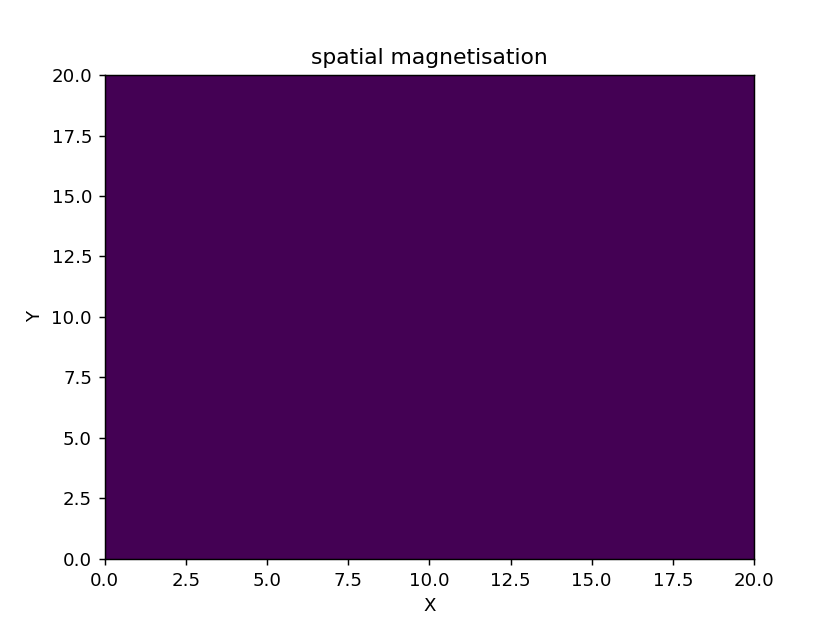

3


<IPython.core.display.Javascript object>


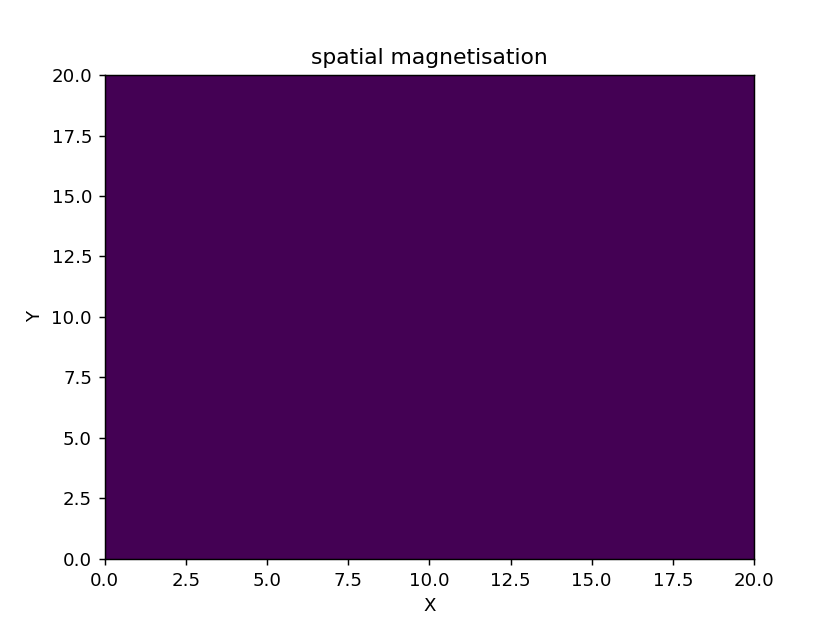

-1.0


In [11]:
l=20
InvTemp=4.0
ising = IsingSimulator(l, InvTemp)
print(ising.performMCS(400))
ising.plotConfig()
print(ising.performMCS(800))
ising.plotConfig()
print(ising.calcMagnetisation())

In [ ]:
ising = IsingSimulator(20, 0.2, 1.0, 0.0)

In [ ]:
ising.plotEquilibrationRun()